In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# view ts insights
from statsmodels.tsa.seasonal import seasonal_decompose

# fit models
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# test for stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# stepwise parameter search
import pmdarima
from pmdarima.arima import auto_arima

# measure model performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Reading Data and Cleaning

In [2]:
#Read CSV File
data = pd.read_csv('ILINet.csv')

#Show Data
data.head(2)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Texas,2010,40,X,2.06514,X,X,X,X,X,X,1050,98,50844
1,States,Texas,2010,41,X,2.09394,X,X,X,X,X,X,1061,97,50670


### Column Types

In [3]:
#Column Types
data.dtypes

REGION TYPE           object
REGION                object
YEAR                   int64
WEEK                   int64
% WEIGHTED ILI        object
%UNWEIGHTED ILI      float64
AGE 0-4               object
AGE 25-49             object
AGE 25-64             object
AGE 5-24              object
AGE 50-64             object
AGE 65                object
ILITOTAL               int64
NUM. OF PROVIDERS      int64
TOTAL PATIENTS         int64
dtype: object

### Columns not needed

In [4]:
### Useless columns:
cols = ['REGION TYPE', 'REGION','% WEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24','AGE 50-64', 'AGE 65']
for col in cols:
    print(col, ':', set(data[col]))

REGION TYPE : {'States'}
REGION : {'Texas'}
% WEIGHTED ILI : {'X'}
AGE 0-4 : {'X'}
AGE 25-49 : {'X'}
AGE 25-64 : {'X'}
AGE 5-24 : {'X'}
AGE 50-64 : {'X'}
AGE 65 : {'X'}


### Extract Columns needed & Rename Columns & Find Missing Values

In [5]:
#We know that the data is for Texas.
data = data[['YEAR', 'WEEK','%UNWEIGHTED ILI','ILITOTAL', 'NUM. OF PROVIDERS', 'TOTAL PATIENTS']]

#Rename Columns
data.columns = ['YEAR', 'WEEK', 'PERC_UNWEIGHTED', 'TOTAL_INFECTED', 'NUM_PROVIDERS', 'TOTAL_PATIENTS']

#-------------------------------------------------
#----------  Count Missing Data  -----------------
#-------------------------------------------------
#Sum the number of NaN in each column for offline data
df_NULL_count = pd.DataFrame(data.isnull().sum(axis = 0))

#Rename the count column
df_NULL_count.rename(columns={0: 'NaN Counts'},inplace=True)

#Create additional calcs
df_NULL_count['Total Row Count'] = data.shape[0]
df_NULL_count['% Missing'] = round(df_NULL_count['NaN Counts'] / data.shape[0] * 100 , 2)

#Sort Data Frame
df_NULL_count.sort_values(by=['% Missing'], inplace=True, ascending=False)

df_NULL_count


,NaN Counts,Total Row Count,% Missing
YEAR,0,505,0.0
WEEK,0,505,0.0
PERC_UNWEIGHTED,0,505,0.0
TOTAL_INFECTED,0,505,0.0
NUM_PROVIDERS,0,505,0.0
TOTAL_PATIENTS,0,505,0.0


### Basic Stats of Features

In [6]:
#There are no missing value. We check the range of values:
data.describe()

,YEAR,WEEK,PERC_UNWEIGHTED,TOTAL_INFECTED,NUM_PROVIDERS,TOTAL_PATIENTS
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2015.097030,26.394059,3.524285,1112.837624,87.819802,30993.994059
std,2.822896,15.241872,2.672913,904.024727,23.163609,9110.683262
min,2010.000000,1.000000,0.794791,56.000000,42.000000,6049.000000
25%,2013.000000,13.000000,1.848060,516.000000,68.000000,24437.000000
50%,2015.000000,26.000000,2.521700,802.000000,92.000000,31054.000000
75%,2018.000000,40.000000,4.152330,1338.000000,108.000000,37908.000000
max,2020.000000,53.000000,15.384100,5203.000000,126.000000,58329.000000


### Remove the last week and basic stats of features

In [7]:
#We remove the last week, The reason that it is far less than others is that its data is incomplete.
data = data[:-1]

data.describe()

,YEAR,WEEK,PERC_UNWEIGHTED,TOTAL_INFECTED,NUM_PROVIDERS,TOTAL_PATIENTS
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,2015.087302,26.400794,3.529441,1114.934524,87.871032,31043.488095
std,2.817214,15.256263,2.673054,903.692750,23.157968,9051.520922
min,2010.000000,1.000000,0.794791,123.000000,42.000000,8496.000000
25%,2013.000000,13.000000,1.854300,517.500000,68.000000,24442.250000
50%,2015.000000,26.000000,2.525295,804.000000,92.000000,31072.000000
75%,2017.250000,40.000000,4.156363,1339.250000,108.000000,37909.750000
max,2020.000000,53.000000,15.384100,5203.000000,126.000000,58329.000000


### Create index that is mid week

In [8]:
###After a lot of checking I found out for this dataset Wednesday date is standard for year
data['mid_week'] = pd.date_range(start='2010-10-06', periods=504, freq='7D')

#data['week_ending'] = pd.to_datetime(data.WEEK.astype(str)+data.YEAR.astype(str).add('-3') ,format='%V%G-%u')

#If you want the dataFrame to be indexed by time run the following otherwise comment it:
data.set_index('mid_week', inplace=True)

#Show Data
data.head(2)

,YEAR,WEEK,PERC_UNWEIGHTED,TOTAL_INFECTED,NUM_PROVIDERS,TOTAL_PATIENTS
mid_week,,,,,,
2010-10-06,2010,40,2.06514,1050,98,50844
2010-10-13,2010,41,2.09394,1061,97,50670


### Column Types and Descriptions

In [9]:
#Column Types
data.dtypes

#Data = PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS
#ILI_TOTAL - Total people with flu symptoms
#NUM_PROVIDERS - Total providers reported for that week
#TOTAL_PATIENTS - Total Patients seen by the clinics

YEAR                 int64
WEEK                 int64
PERC_UNWEIGHTED    float64
TOTAL_INFECTED       int64
NUM_PROVIDERS        int64
TOTAL_PATIENTS       int64
dtype: object

# EDA

### Create Series Data Set

In [10]:
#Create a series data of total people with flu like symptoms
series = data['TOTAL_INFECTED']

#Show Data
series.head(2)

mid_week
2010-10-06    1050
2010-10-13    1061
Name: TOTAL_INFECTED, dtype: int64

### Calculate the number of days in Data Set

In [11]:
index = series.index

#Get range
days_range = index.max() - index.min()

print('Calculated Days:', days_range.days/7 + 1)
print('Exact Days:', data.shape[0])

Calculated Days: 504.0
Exact Days: 504


### Resample Data Set to Determine if any Missing Weeks

In [12]:
#Re-sample data every 7 days
series_re = series.resample('7D').first()

#Should be 0
series_re[series_re.isnull()]

Series([], Freq: 7D, Name: TOTAL_INFECTED, dtype: int64)

### Plot Series Data

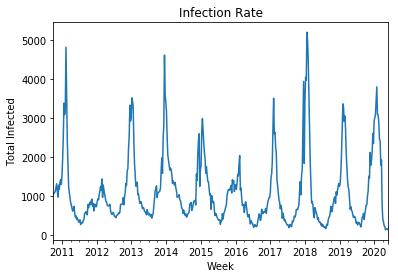

In [13]:
series.plot()
plt.title('Infection Rate')
plt.xlabel('Week')
plt.ylabel('Total Infected')
plt.show()

### Plot Series Data by Month

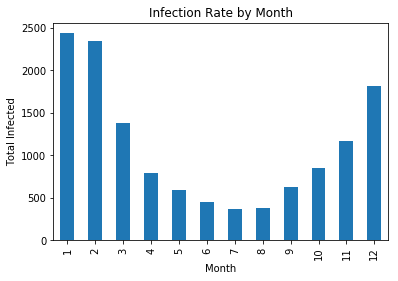

In [14]:
series.groupby(series.index.month).mean().plot(kind='bar')
plt.title('Infection Rate by Month')
plt.xlabel('Month')
plt.ylabel('Total Infected')
plt.show()

In [ ]:
#Plot Data by week, looks like month not really useful
#series.groupby(series.index.week).mean().plot(kind='bar')

### Plot Series Data by Year

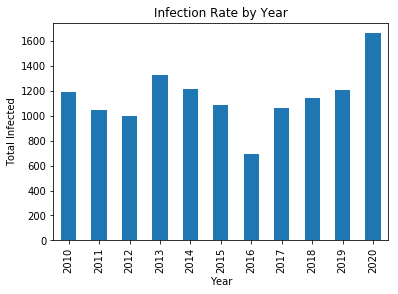

In [15]:
series.groupby(series.index.year).mean().plot(kind='bar')
plt.title('Infection Rate by Year')
plt.xlabel('Year')
plt.ylabel('Total Infected')
plt.show()

### Decomposition Plots

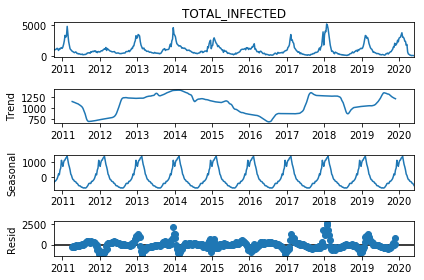

In [16]:
#Adding the Trends
decomposition = seasonal_decompose(series)

decomposition.plot()
plt.show()

In [17]:
series.head()

mid_week
2010-10-06    1050
2010-10-13    1061
2010-10-20    1090
2010-10-27    1117
2010-11-03    1218
Name: TOTAL_INFECTED, dtype: int64

In [18]:
series.tail()

mid_week
2020-04-29    128
2020-05-06    156
2020-05-13    153
2020-05-20    150
2020-05-27    123
Name: TOTAL_INFECTED, dtype: int64

# Modeling
## Test for Stationarity

In [19]:
# Adjusted Dickey-Fuller + KPSS + Plot of Rolling Statistics
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: {}'.format(dftest[0]))
    print('p-value: {}'.format(dftest[1]))
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t{}: {}'.format(key, value))
          
    # Perform KPSS test:
    print('\nResults of KPSS Test: ')
    statistic, p_value, n_lags, critical_values = kpss(timeseries)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [21]:
# data was resampled into weekly but no frequency was added into resample

# add frequency trait
series = series.asfreq('W-Wed')

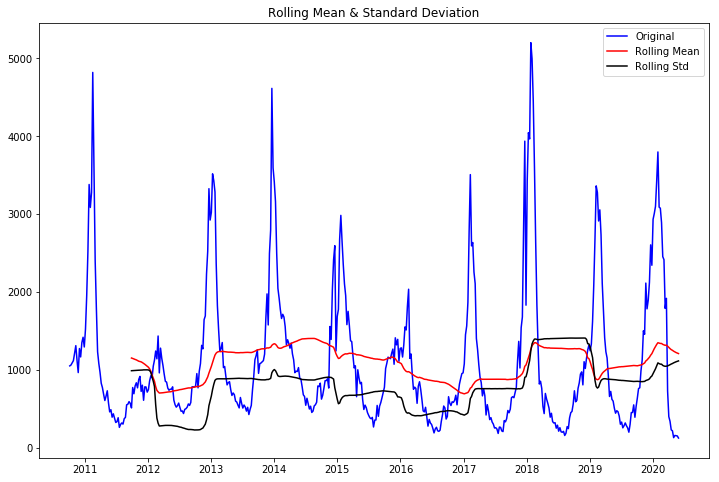

Results of Dickey-Fuller Test: 
ADF Statistic: -5.880182568884478
p-value: 3.091539958389782e-07
Critical Values:
	1%: -3.443496379464
	5%: -2.8673378563200003
	10%: -2.569858036

Results of KPSS Test: 
KPSS Statistic: 0.03138951792816754
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\javie\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\javie\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [22]:
test_stationarity(series)

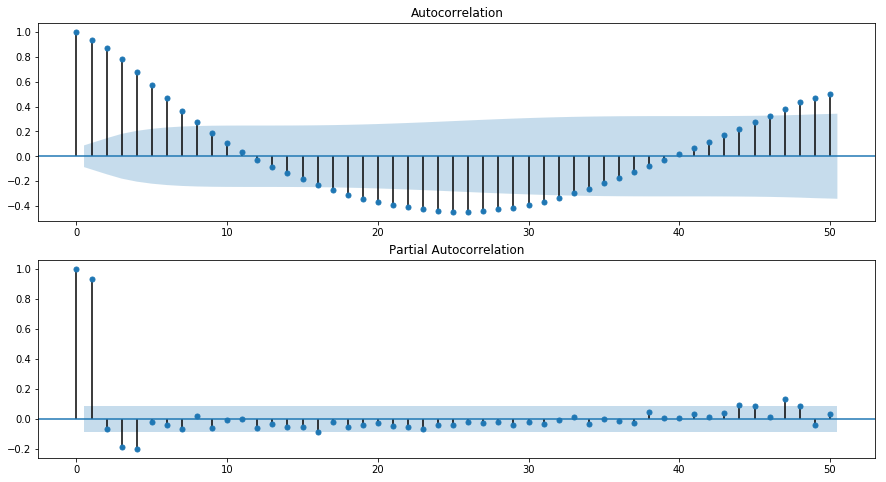

In [23]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax[1])
plt.show()

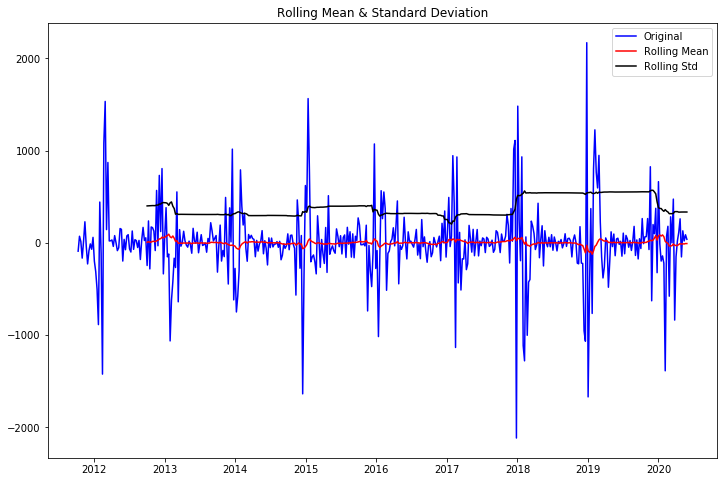

Results of Dickey-Fuller Test: 
ADF Statistic: -8.746608168177286
p-value: 2.9112619516226206e-14
Critical Values:
	1%: -3.445299682487321
	5%: -2.8681312035123967
	10%: -2.570280872933884

Results of KPSS Test: 
KPSS Statistic: 0.02358345657567589
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\javie\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [24]:
d = 1 # difference of first order (log transformation may be more appropriate to fully stationarize)
s = 52 # 52 weeks in a year
differenced_series = series - series.shift(d)
differenced_seasonal_series = differenced_series - differenced_series.shift(s)

test_stationarity(differenced_seasonal_series.dropna())

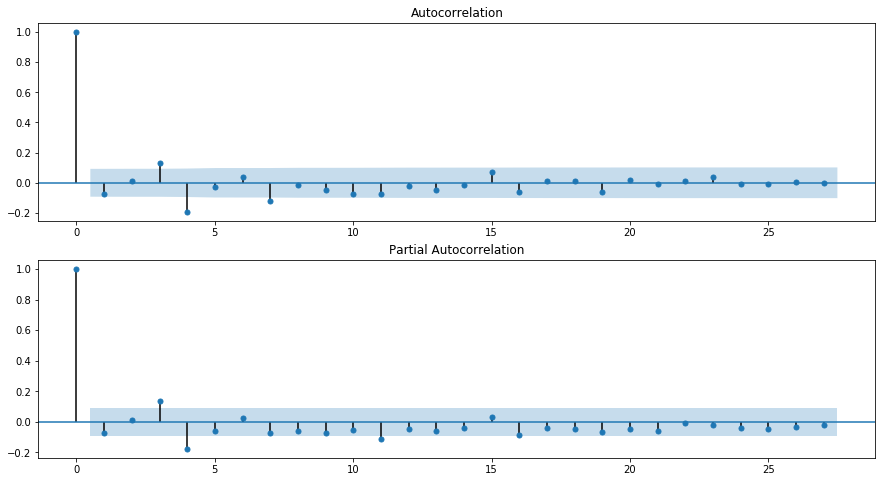

In [25]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(differenced_seasonal_series.dropna(), ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(differenced_seasonal_series.dropna(), ax=ax[1])
plt.show()

In [26]:
# create start dates and end dates for test, train, and prediction data sets
train_start,train_end = '2011-01-01','2016-12-31'
test_start,test_end = '2019-01-01','2019-12-31'
preds_start,preds_end = '2020-01-01','2020-05-27'

# create train, test, and predictions data set
train = series[train_start:train_end].dropna()
test = series[test_start:test_end].dropna()
preds = series[preds_start:preds_end].dropna()

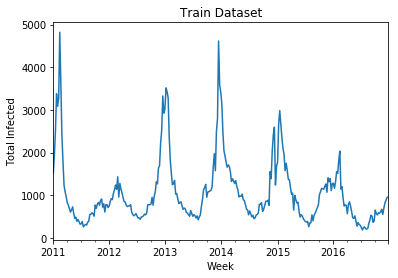

In [32]:
train.plot()
plt.title('Train Dataset')
plt.xlabel('Week')
plt.ylabel('Total Infected')
plt.show()

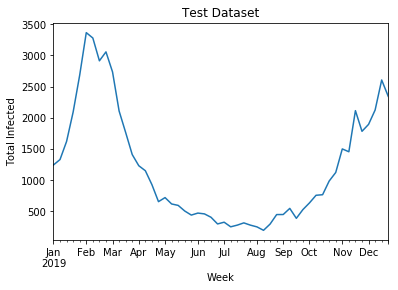

In [33]:
test.plot()
plt.title('Test Dataset')
plt.xlabel('Week')
plt.ylabel('Total Infected')
plt.show()

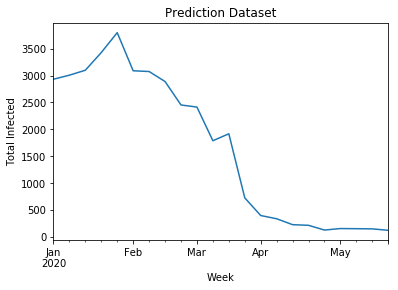

In [34]:
preds.plot()
plt.title('Prediction Dataset')
plt.xlabel('Week')
plt.ylabel('Total Infected')
plt.show()

## Stepwise Parameter Search

In [102]:
# Stepwise Search for ARIMA orders
arima_sw=auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=False, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4426.155, BIC=4441.127, Time=0.202 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4423.821, BIC=4431.307, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4425.520, BIC=4436.749, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4425.604, BIC=4436.833, Time=0.088 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=4421.833, BIC=4425.576, Time=0.008 seconds
Total fit time: 0.346 seconds


In [28]:
# Stepwise Search for SARIMA orders

# ******************************************************************************************************
# * This part takes about 36 minutes to run so run at your own risk. There shouldn't be a reason to re-*
# * run this part unless the test, train, and/or preds window gets changed. If so, get comfortable or  *
# * consider minimizing the window to reduce search time. Minimizing search time may affect performance*
# * of the model recommended by the search.                                                            *
# ******************************************************************************************************

sarima_sw=auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=52, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,0,52) [intercept=True]; AIC=3781.078, BIC=3795.321, Time=4.519 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=3779.141, BIC=3786.263, Time=0.965 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=3752.032, BIC=3766.274, Time=26.031 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=3727.961, BIC=3742.204, Time=62.276 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=3777.148, BIC=3780.709, Time=0.832 seconds
Fit ARIMA(1,1,0)x(0,1,0,52) [intercept=True]; AIC=3779.096, BIC=3789.778, Time=0.936 seconds
Fit ARIMA(1,1,0)x(2,1,0,52) [intercept=True]; AIC=3750.964, BIC=3768.767, Time=80.433 seconds
Fit ARIMA(1,1,0)x(3,1,0,52) [intercept=True]; AIC=3723.107, BIC=3744.472, Time=131.435 seconds
Near non-invertible roots for order (1, 1, 0)(3,

In [103]:
# ARIMA orders, AIC, and BIC from stepwise
print(arima_sw)
print('AIC: ', arima_sw.aic())
print('BIC: ', arima_sw.bic())

ARIMA(order=(0, 1, 0), suppress_warnings=True, with_intercept=False)
AIC:  4421.832867242612
BIC:  4425.575870430422


In [30]:
# SARIMA orders, AIC, and BIC from stepwise
print(sarima_sw)
print('AIC: ', sarima_sw.aic())
print('BIC: ', sarima_sw.bic())

ARIMA(order=(0, 1, 0), seasonal_order=(3, 1, 1, 52), suppress_warnings=True)
AIC:  3711.835064811239
BIC:  3733.1991545973324


## Fit the Models

In [141]:
# Fit the models
ARIMA = sm.tsa.statespace.SARIMAX(train, order=(0,1,0)).fit()
SARIMA = sm.tsa.statespace.SARIMAX(train, order=(0,1,0), seasonal_order=(3,1,1,52)).fit()

In [142]:
# view coefficients
print(ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:         TOTAL_INFECTED   No. Observations:                  313
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2209.916
Date:                Mon, 29 Jun 2020   AIC                           4421.833
Time:                        00:50:34   BIC                           4425.576
Sample:                    01-05-2011   HQIC                          4423.329
                         - 12-28-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.314e+04   2578.159     32.247      0.000    7.81e+04    8.82e+04
Ljung-Box (Q):                       21.73   Jarque-Bera (JB):              1690.34
Prob(Q):                              0.99   Pr

In [143]:
# view cefficients
print(SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       TOTAL_INFECTED   No. Observations:                  313
Model:             SARIMAX(0, 1, 0)x(3, 1, [1], 52)   Log Likelihood               -1849.931
Date:                              Mon, 29 Jun 2020   AIC                           3709.862
Time:                                      00:50:35   BIC                           3727.666
Sample:                                  01-05-2011   HQIC                          3717.019
                                       - 12-28-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.0984      0.053     -1.861      0.063      -0.202       0.005
ar.S.L104     -0.20

## Diagnosis of Fitness 

In [154]:
# Store predictions for each model
arima_pred = ARIMA.predict(test_start,test_end)[1:]
sarima_pred = SARIMA.predict(test_start,test_end)[1:]

arima_pred = arima_pred.resample('7D').first()
sarima_pred = sarima_pred.resample('7D').first()

In [155]:
# fitness for ARIMA model
print('ARIMA (0,1,0)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(test,arima_pred, squared=False)))
print('r2:{}'.format(r2_score(test,arima_pred)))
print('MAE:{}'.format(mean_absolute_error(test,arima_pred)))

ARIMA (0,1,0)
------------------------
RMSE:943.8960381150197
r2:-0.07360929949058481
MAE:749.4615384615385


In [156]:
# fitness for SARIMA model
print('SARIMA (0,1,0)(3,1,1,52)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(test,sarima_pred, squared=False)))
print('r2:{}'.format(r2_score(test,sarima_pred)))
print('MAE:{}'.format(mean_absolute_error(test,sarima_pred)))

SARIMA (0,1,0)(3,1,1,52)
------------------------
RMSE:998.3591052649873
r2:-0.20107880878078488
MAE:825.6735094874855


In [157]:
# Store all predictions in dataframe
results = pd.DataFrame({'ACTUAL':test, 'ARIMA':arima_pred, 'SARIMA':sarima_pred}).dropna()
results.head()

,ACTUAL,ARIMA,SARIMA
2019-01-09,1331.0,960.0,1919.680905
2019-01-16,1621.0,960.0,1950.077758
2019-01-23,2092.0,960.0,1538.892590
2019-01-30,2684.0,960.0,1342.279989
2019-02-06,3363.0,960.0,1404.728587


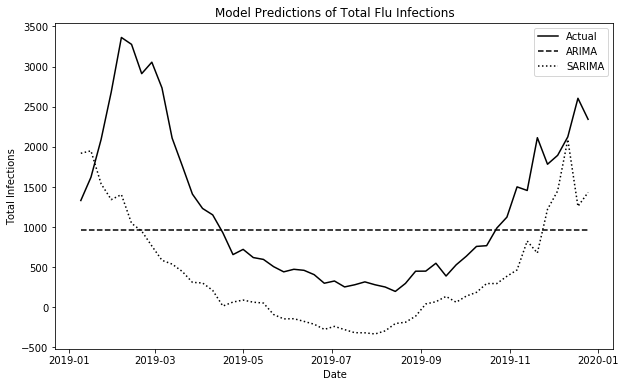

In [158]:
# Plot predictions
plt.figure(figsize=(10,6))
plt.plot(results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(results.ARIMA, label = "ARIMA",  color = 'black', linestyle='dashed')
plt.plot(results.SARIMA, label = "SARIMA",  color = 'black', linestyle='dotted')
plt.title('Model Predictions of Total Flu Infections')
plt.ylabel('Total Infections')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

# plt.savefig("preds.png")

plt.show()

## Forecast and Validate

In [159]:
# validation for final output
final_pred = SARIMA.predict(preds_start,preds_end)
print('SARIMA (0,1,0)(3,1,1,52)\n------------------------')
print('RMSE:{}'.format(mean_squared_error(preds,final_pred, squared=False)))
print('r2:{}'.format(r2_score(preds,final_pred)))
print('MAE:{}'.format(mean_absolute_error(preds,final_pred)))

SARIMA (0,1,0)(3,1,1,52)
------------------------
RMSE:1304.3951701684607
r2:0.06260066872573866
MAE:994.862109408993


In [160]:
# store final results
final_results = pd.DataFrame({'ACTUAL':preds,'SARIMA':final_pred})

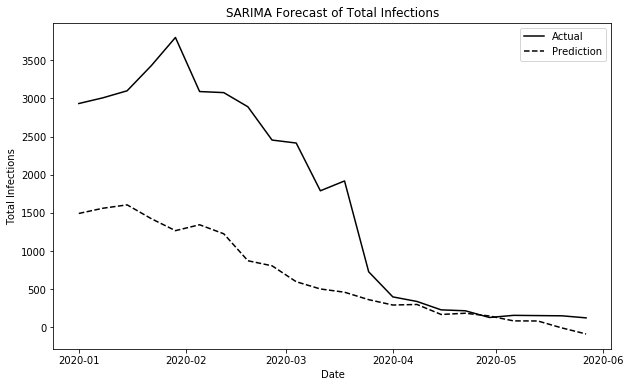

In [161]:
# Plot SARIMA predictions
plt.figure(figsize=(10,6))
plt.plot(final_results.ACTUAL, label = "Actual",  color = 'black', linestyle='solid')
plt.plot(final_results.SARIMA, label = "Prediction",  color = 'black', linestyle='dashed')
plt.title('SARIMA Forecast of Total Infections')
plt.ylabel('Total Infections')
plt.xlabel('Date')
plt.grid(False)
plt.legend()

# plt.savefig("forecast.png")

plt.show()

Model is underperforming because the wrong models were selected for this exercise. An ARIMA and SARIMA model are designed to capture the movement of the model and not prioritize the signal so much. In this case, the ARIMA and SARIMA models both indicated the noise within the signal was white noise, which is why the models were 0,1,0. The SARIMA attempts to model the signal and does a good job doing so but fails to match the 'noise' it thinks the true data is presenting. The best way to circumvent this is by using a signal plus noise model. That model will utilize the signal as the priority and disregard the movements within the signal as white noise. If we insisted on using ARIMA/SARIMA models, then the best course of action would be to increase the level of detail to monthly data instead of weekly. The monthly data would rid of the 'noise' and just present the signal to get modeled.